In [9]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool, cpu_count

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [10]:
dfAll = pd.read_pickle("DataStudyCollection/AllData.pkl")
df = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
7919,17,1547138928692,1,680,6,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7920,17,1547138928735,1,680,6,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7921,17,1547138928773,1,680,6,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7922,17,1547138928813,1,680,6,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7923,17,1547138928861,1,680,6,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
%%time
def is_max(df):
    df_temp = df.copy(deep=True)
    max_version = df_temp.RepetitionID.max()
    df_temp["IsMax"] = np.where(df_temp.RepetitionID == max_version, True, False)
    df_temp["MaxRepetition"] = [max_version] * len(df_temp)
    return df_temp

df_grp = df.groupby([df.userID, df.TaskID, df.VersionID])
pool = Pool(cpu_count() - 1)
result_lst = pool.map(is_max, [grp for name, grp in df_grp])
df = pd.concat(result_lst)
pool.close()

CPU times: user 39 s, sys: 5.78 s, total: 44.8 s
Wall time: 43.3 s


In [12]:
df.Image = df.Image.apply(lambda x: x.reshape(27, 15))
df.Image = df.Image.apply(lambda x: x.clip(min=0, max=255))
df.Image = df.Image.apply(lambda x: x.astype(np.uint8))
df["ImageSum"] = df.Image.apply(lambda x: np.sum(x))

In [13]:
df.to_pickle("DataStudyCollection/dfFiltered.pkl")

In [14]:
print("recorded actual: %s, used data: %s" % (len(dfAll), len(df)))

recorded actual: 1010014, used data: 851455


In [15]:
df = pd.read_pickle("DataStudyCollection/dfFiltered.pkl")

In [16]:
df.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,IsMax,MaxRepetition,ImageSum
291980,1,"1,54515E+12",33,680,0,2,0,True,False,"[[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0]...",True,0,307
291981,1,"1,54515E+12",33,680,0,2,0,True,False,"[[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0]...",True,0,222
291982,1,"1,54515E+12",33,680,0,2,0,True,False,"[[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0]...",True,0,521
291983,1,"1,54515E+12",33,680,0,2,0,True,False,"[[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0]...",True,0,318
291984,1,"1,54515E+12",33,680,0,2,0,True,False,"[[0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 1, 1, 1, 0]...",True,0,373


In [26]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df['InputMethod'] = df.apply(f, axis=1)

def f(row):
    if row['TaskID'] < 17:
        val = "Knuckle"
    elif row['TaskID'] >= 17:
        val = "Finger"
    return val
df['Input'] = df.apply(f, axis=1)

In [17]:
#Svens new Blob detection
def detect_blobs(image, task):
    #image = e.Image
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = np.copy(image)
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    contours.sort(key=lambda a: cv2.contourArea(a))
    if len(contours) > 0:
        # if two finger or knuckle
        cont_count = 2 if task in [1, 6, 7, 18, 23, 24] and len(contours) > 1 else 1
        for i in range(1, cont_count + 1):
            max_contour = contours[-1 * i]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            #croped_im = np.zeros((27,15))
            blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
            #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            #return (1, [croped_im])
            lstBlob.append(blob)
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            count = count + 1
        return (count, lstBlob, lstMin, lstMax)
    else:
        return (0, [np.zeros((29, 19))], 0, 0)

In [18]:
%%time
pool = Pool(os.cpu_count()-2)
temp_blobs = pool.starmap(detect_blobs, zip(df.Image, df.TaskID))
pool.close()

CPU times: user 11.9 s, sys: 7.51 s, total: 19.4 s
Wall time: 18.6 s


In [19]:
df["BlobCount"] = [a[0] for a in temp_blobs]
df["BlobImages"] = [a[1] for a in temp_blobs]
df["BlobW"] = [a[2] for a in temp_blobs]
df["BlobH"] = [a[3] for a in temp_blobs]

In [20]:
df.BlobCount.value_counts()

0    710145
1    128117
2     13193
Name: BlobCount, dtype: int64

In [21]:
dfX = df[(df.BlobCount == 1)].copy(deep=True)
dfX.BlobImages = dfX.BlobImages.apply(lambda x : x[0])
dfX.BlobW = dfX.BlobW.apply(lambda x : x[0])
dfX.BlobH = dfX.BlobH.apply(lambda x : x[0])

dfY = df[(df.BlobCount == 2)].copy(deep=True)
dfY.BlobImages = dfY.BlobImages.apply(lambda x : x[0])
dfY.BlobW = dfY.BlobW.apply(lambda x : x[0])
dfY.BlobH = dfY.BlobH.apply(lambda x : x[0])

dfZ = df[(df.BlobCount == 2)].copy(deep=True)
dfZ.BlobImages = dfZ.BlobImages.apply(lambda x : x[1])
dfZ.BlobW = dfZ.BlobW.apply(lambda x : x[1])
dfZ.BlobH = dfZ.BlobH.apply(lambda x : x[1])

df = dfX.append([dfY, dfZ])

In [22]:
print("Sample Size not Argumented:", len(df))

Sample Size not Argumented: 154503


In [23]:
df["BlobArea"] = df["BlobW"] * df["BlobH"]

In [24]:
df.BlobArea.describe().round(1)

count    154503.0
mean         15.8
std           5.1
min          12.0
25%          12.0
50%          16.0
75%          16.0
max         110.0
Name: BlobArea, dtype: float64

In [27]:
df.groupby("Input").BlobArea.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
Input,,,,,,,,
Finger,110839.0,16.6,5.3,12.0,12.0,16.0,16.0,110.0
Knuckle,43664.0,13.7,3.7,12.0,12.0,12.0,16.0,72.0


In [ ]:
df["BlobSum"] = df.BlobImages.apply(lambda x: np.sum(x))

In [ ]:
df.BlobSum.describe()

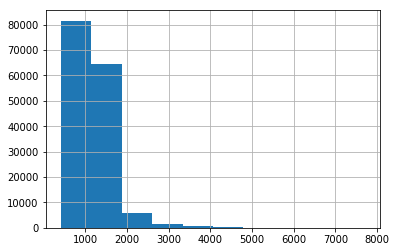

In [27]:
df.BlobSum.hist()

In [28]:
#Small / Blobs where the pixels are only a "little" hit
dfX = df[df.BlobSum <= 255]
len(dfX)

0

In [29]:
#Augmenting by flipping in both axis (datax4)
df["Version"] = "Normal"
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.flipud(x))
dfFlipped["Version"] = "FlippedUD"
df = df.append(dfFlipped)
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.fliplr(x))
dfFlipped["Version"] = "FlippedLR"
df = df.append(dfFlipped)

In [30]:
print("Sample Size argumented:", len(df))

Sample Size argumented: 618012


In [31]:
def pasteToEmpty (blob):
    croped_im = np.zeros((27,15))
    croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
    return croped_im

In [32]:
df["Blobs"] = df.BlobImages.apply(lambda x: pasteToEmpty(x))

In [34]:
df.to_pickle("DataStudyCollection/df_statistics.pkl")

In [35]:
df[["userID", "TaskID", "Version", "Blobs", "InputMethod"]].to_pickle("DataStudyCollection/df_blobs_area.pkl")

# display blobs

userID                                                           1
Timestamp                                              1,54515E+12
Current_Task                                                   121
Task_amount                                                    680
TaskID                                                           0
VersionID                                                        7
RepetitionID                                                     0
Actual_Data                                                   True
Is_Pause                                                     False
Image            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
IsMax                                                         True
MaxRepetition                                                    0
ImageSum                                                      1495
BlobCount                                                        1
BlobImages       [[2, 2, 11, 11, 2], [2, 9, 40, 42, 9], [4, 13

<Figure size 432x288 with 0 Axes>

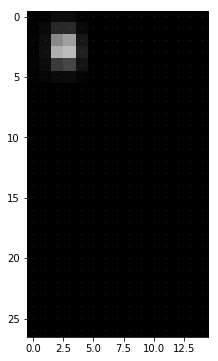

In [36]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 100
data = df.Blobs.iloc[data_point]
print(df.iloc[data_point])
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
plt.show()